<a href="https://colab.research.google.com/github/tonchan1216/bitbot/blob/master/notebook/predict_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
from google.colab import drive
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## データの読み込み

In [153]:
drive.mount('/content/drive/')

base_path = '/content/drive/My Drive/Colab Notebooks/bitbot/training_data/'
train_data = pd.read_csv(base_path + 'btc_all.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 前処理

shift => shift = (入力となる日数: 7) + (トレンドを予測する日数: 1)

threashold => 上昇率N％以上で、上昇。下降率N％以下で、下降。それ以外は停滞

In [154]:
def process(input_df, shift = 8, threshold = 0.02):
  ## データを一週間分シフト
  x = pd.concat([input_df.shift(-1*i) for i in range(shift)], axis=1)
  x = x.dropna()
  x = x.set_axis([str(i-6) for i in range(shift)], axis=1)

  ## 変動率の算出
  change_rate = (x['1'] - x['0']) / x['0']

  ## データの標準化
  m = np.array(x.mean(axis='columns'))
  s = np.array(x.std(axis='columns'))
  x = x.sub(m, axis=0).div(s, axis=0)

  ## 正解データの作成
  y = pd.DataFrame({'up': np.zeros(len(x)), 'down': np.zeros(len(x)), 'even': np.zeros(len(x))})
  y.loc[change_rate > threshold, 'up'] = 1 # 上昇トレンド
  y.loc[change_rate < -threshold, 'down'] = 1 # 下降トレンド
  y.loc[(change_rate <= threshold) & (change_rate >= -threshold), 'even'] = 1 # 停滞トレンド

  x = x.drop('1',axis=1)
  return np.array(x), np.array(y)

reference_day = 7
input_tensor, label_tensor = process(train_data['BTC'], shift = reference_day + 1, threshold = 0.01)
train_x, test_x, train_y, test_y = train_test_split(input_tensor, label_tensor, test_size=0.2, random_state=100, shuffle = True)

print('train data num: ', train_x.shape[0])
print(np.count_nonzero(train_y == 1, axis=0))

print('test data num: ', test_x.shape[0])
print(np.count_nonzero(test_y == 1, axis=0))

train data num:  1897
[665 533 699]
test data num:  475
[173 132 170]


## Model構築

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 7)                 252       
                                                                 
 dense_26 (Dense)            (None, 3)                 24        
                                                                 
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________
None


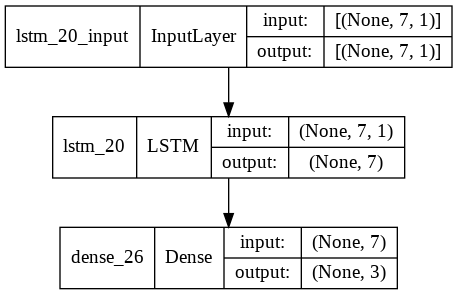

In [155]:
optimizer = Nadam()

model = Sequential()
## 入力層
model.add(LSTM(reference_day,
             dropout=0.2,
             recurrent_dropout=0,
             input_shape=(reference_day,1)))
## 中間層(なし)
# model.add(Dropout(0.2))
# model.add(Dense(5, activation='relu'))
## 出力層
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=optimizer,
           loss='categorical_crossentropy',
           metrics=['acc'])

print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

## 学習

scrkit-learnと同様fitで記述できる

In [156]:
earlystopping = EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_x, train_y,
 batch_size=10,
 epochs=100,
 callbacks=[earlystopping],
 verbose=1,
 validation_data=(test_x, test_y))

Epoch 1/100
190/190 [==============================] - 5s 11ms/step - loss: 1.0980 - acc: 0.3289 - val_loss: 1.0757 - val_acc: 0.4568
Epoch 2/100
190/190 [==============================] - 1s 7ms/step - loss: 1.0590 - acc: 0.4391 - val_loss: 1.0129 - val_acc: 0.5284
Epoch 3/100
190/190 [==============================] - 1s 7ms/step - loss: 1.0153 - acc: 0.4945 - val_loss: 0.9609 - val_acc: 0.5474
Epoch 4/100
190/190 [==============================] - 2s 8ms/step - loss: 1.0054 - acc: 0.4802 - val_loss: 0.9355 - val_acc: 0.6000
Epoch 5/100
190/190 [==============================] - 1s 7ms/step - loss: 1.0009 - acc: 0.5076 - val_loss: 0.9171 - val_acc: 0.6042
Epoch 6/100
190/190 [==============================] - 1s 7ms/step - loss: 0.9841 - acc: 0.5024 - val_loss: 0.8995 - val_acc: 0.6421
Epoch 7/100
190/190 [==============================] - 1s 7ms/step - loss: 0.9978 - acc: 0.5161 - val_loss: 0.8994 - val_acc: 0.6358
Epoch 8/100
190/190 [==============================] - 2s 8ms/step -

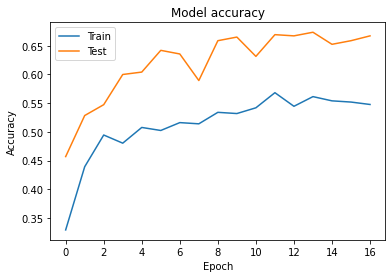

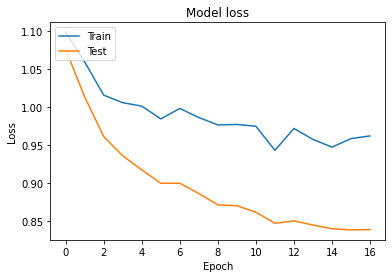

In [157]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 評価

evaluateで行う

In [158]:
test_loss, test_acc = model.evaluate(test_x[:,:,np.newaxis], test_y)

15/15 [==============================] - 1s 4ms/step - loss: 0.8386 - acc: 0.6674
